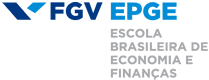

## Rafael Kovashikawa

#### Econometrics II

#### Rio de Janeiro, 2020.2

----



# 1 Introduction:

This work is an effort to analyse the relatioship between Bitcoin, Gold and the NASDAQ index prices over the time in a macroeconomical perspective.

Hence the use of a Vector Auto Regression (VAR) is appropriated to study these relations, the use of Granger Causality, allowing us to move further and use an impulse-response analysis, by tracing out the dynamic impact of these shocks on subsequent movements in all of the macroeconomic variables. Also it is shown that the effects of a VAR can be used for price prediction in window calculated, but this is not the objective in this work.

In [108]:
library(tidyverse)
library(forecast)
library(reshape2)
library(mFilter)
library(tseries)
library(lmtest)
library(dplyr)
library(readr)
library(urca)
library(vars)

In [2]:
yahoof_gc_f_link <- 'https://query1.finance.yahoo.com/v7/finance/download/GC=F?period1=967593600&period2=1606003200&interval=1d&events=history&includeAdjustedClose=true'

yahoof_btc_usd_link <- 'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410825600&period2=1606003200&interval=1d&events=history&includeAdjustedClose=true'

yahoof_nasdaq_link <- 'https://query1.finance.yahoo.com/v7/finance/download/%5EIXIC?period1=1388534400&period2=1606089600&interval=1d&events=history&includeAdjustedClose=true'

nasdaq    <- read_delim(yahoof_nasdaq_link, ",")

nasdaq$Weekday <- weekdays(as.Date(nasdaq$Date))

gc_f    <- read_delim(yahoof_gc_f_link, ",")

btc_usd <- read_delim(yahoof_btc_usd_link, ",")

gc_f    <- gc_f[gc_f$Date >= min(btc_usd$Date),]

us_non_holidays <- gc_f[gc_f$Open != 'null',]$Date

btc_usd <- btc_usd[btc_usd$Date %in% us_non_holidays ,] 

nasdaq <-  nasdaq[nasdaq$Date %in% us_non_holidays ,] 

gc_f <- gc_f[gc_f$Open != 'null',]

gc_f[, c(2:7)] <- sapply(gc_f[, c(2:7)], as.numeric)

gc_f$Weekday <- weekdays(as.Date(gc_f$Date))

btc_usd$Weekday <- weekdays(as.Date(btc_usd$Date))

btc_usd <- btc_usd[btc_usd$Weekday != 'Saturday',]

btc_usd <- btc_usd[btc_usd$Weekday != 'Sunday',]

gc_f <- gc_f[gc_f$Weekday != 'Saturday',]

gc_f <- gc_f[gc_f$Weekday != 'Sunday',]



Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Open = col_double(),
  High = col_double(),
  Low = col_double(),
  Close = col_double(),
  `Adj Close` = col_double(),
  Volume = col_double()
)
Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Open = col_character(),
  High = col_character(),
  Low = col_character(),
  Close = col_character(),
  `Adj Close` = col_character(),
  Volume = col_character()
)
Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Open = col_double(),
  High = col_double(),
  Low = col_double(),
  Close = col_double(),
  `Adj Close` = col_double(),
  Volume = col_double()
)


In [3]:
dim(gc_f)

[1] 1545    8

In [4]:
dim(btc_usd)

[1] 1545    8

In [5]:
dim(nasdaq)

[1] 1545    8

1545 days for analysis

---

# Augmented Dickey-Fuller Test (ADF):

The Dickey-Fuller test is testing if $\phi=0$ in this model of the data:
$$y_t = \alpha + \beta t + \phi y_{t-1} + e_t$$
which is written as
$$\Delta y_t = y_t-y_{t-1}= \alpha + \beta t + \gamma y_{t-1} + e_t$$
where $y_t$ is your data.  It is written this way so we can do a linear regression of $\Delta y_t$ against $t$ and $y_{t-1}$ and test if $\gamma$ is different from 0.  If $\gamma=0$, then we have a random walk process. If not and $-1<1+\gamma<1$, then we have a stationary process.

### Augmented Dickey-Fuller test

The Augmented Dickey-Fuller test allows for higher-order autoregressive processes by including $\Delta y_{t-p}$ in the model.  But our test is still if $\gamma = 0$.
$$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + \dots$$

The null hypothesis for both tests is that the data are non-stationary.  We want to REJECT the null hypothesis for this test, so we want a p-value of less that 0.05 (or smaller).

---
### ADF for BTC

In [6]:
x=ur.df(btc_usd$'Adj Close', type = "drift", lags = 0)

summary(x)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2952.8   -37.1    -9.5    37.3  3595.3 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 1.122e+01  1.242e+01   0.903    0.366
z.lag.1     1.172e-04  1.956e-03   0.060    0.952

Residual standard error: 332.9 on 1542 degrees of freedom
Multiple R-squared:  2.327e-06,	Adjusted R-squared:  -0.0006462 
F-statistic: 0.003589 on 1 and 1542 DF,  p-value: 0.9522


Value of test-statistic is: 0.0599 0.9658 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.43 -2.86 -2.57
phi1  6.43  4.59  3.78


### So the p-value is large and the series is stationary, therefore we should use the approach in the Box-Jenkins method which is to use differencing:

In [7]:
x2 = diff(btc_usd$'Adj Close')
x3 = ur.df(x2, type = "drift", lags=0)

summary(x3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2952.6   -37.0   -10.2    38.1  3642.0 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.01003    8.48113   1.416    0.157    
z.lag.1     -1.01927    0.02552 -39.946   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 333 on 1541 degrees of freedom
Multiple R-squared:  0.5087,	Adjusted R-squared:  0.5084 
F-statistic:  1596 on 1 and 1541 DF,  p-value: < 2.2e-16


Value of test-statistic is: -39.9462 797.852 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.43 -2.86 -2.57
phi1  6.43  4.59  3.78


### Now we have an non-stationary series with a very small p-value.

This is going to be used for Gold and NASDAQ ADF tests.

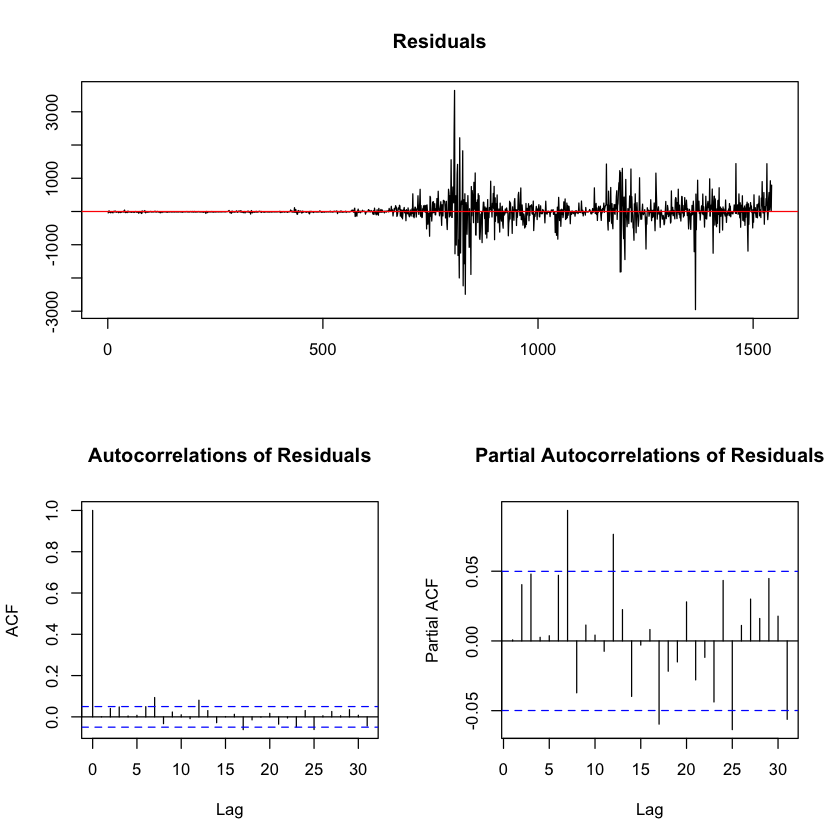

In [8]:
plot(x3)

---

### ADF for GOLD FUTURES

In [9]:
x=ur.df(gc_f$'Adj Close', type = "drift", lags = 0)

summary(x)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-97.550  -5.907  -0.110   6.290  92.773 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 3.331e-01  2.210e+00   0.151    0.880
z.lag.1     6.013e-05  1.636e-03   0.037    0.971

Residual standard error: 13.26 on 1542 degrees of freedom
Multiple R-squared:  8.76e-07,	Adjusted R-squared:  -0.0006476 
F-statistic: 0.001351 on 1 and 1542 DF,  p-value: 0.9707


Value of test-statistic is: 0.0368 0.7512 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.43 -2.86 -2.57
phi1  6.43  4.59  3.78


In [10]:
x2 = diff(gc_f$'Adj Close')
x3 = ur.df(x2, type = "drift", lags=0)

summary(x3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-97.417  -5.781  -0.158   6.292  94.624 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.42831    0.33762   1.269    0.205    
z.lag.1     -1.02232    0.02547 -40.139   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.26 on 1541 degrees of freedom
Multiple R-squared:  0.5111,	Adjusted R-squared:  0.5108 
F-statistic:  1611 on 1 and 1541 DF,  p-value: < 2.2e-16


Value of test-statistic is: -40.1388 805.5616 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.43 -2.86 -2.57
phi1  6.43  4.59  3.78


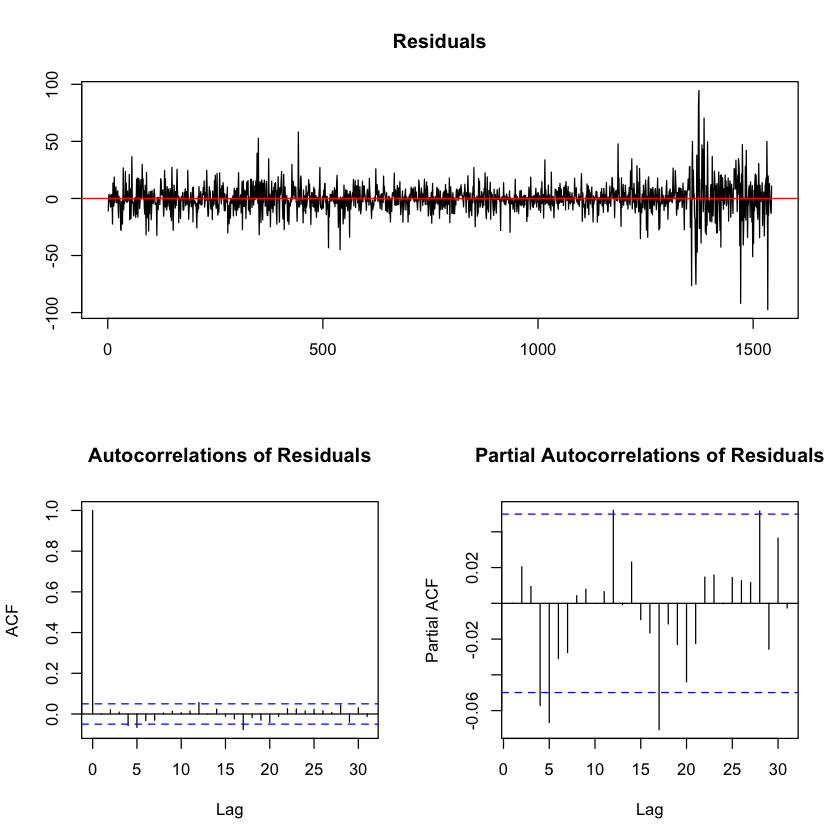

In [11]:
plot(x3)

---
### ADF for NASDAQ INDEX

In [12]:
x=ur.df(nasdaq$'Adj Close', type = "drift", lags = 0)

summary(x)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-975.69  -30.06    2.95   41.23  668.08 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.6667308  9.5081426   0.070    0.944
z.lag.1     0.0006013  0.0013594   0.442    0.658

Residual standard error: 98.53 on 1542 degrees of freedom
Multiple R-squared:  0.0001269,	Adjusted R-squared:  -0.0005216 
F-statistic: 0.1956 on 1 and 1542 DF,  p-value: 0.6583


Value of test-statistic is: 0.4423 1.872 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.43 -2.86 -2.57
phi1  6.43  4.59  3.78


In [13]:
x2 = diff(nasdaq$'Adj Close')
x3 = ur.df(x2, type = "drift", lags=0)

summary(x3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-844.47  -30.84    4.07   41.07  547.87 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.63547    2.46372   2.287   0.0223 *  
z.lag.1     -1.19530    0.02499 -47.840   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 96.66 on 1541 degrees of freedom
Multiple R-squared:  0.5976,	Adjusted R-squared:  0.5974 
F-statistic:  2289 on 1 and 1541 DF,  p-value: < 2.2e-16


Value of test-statistic is: -47.8396 1144.316 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.43 -2.86 -2.57
phi1  6.43  4.59  3.78


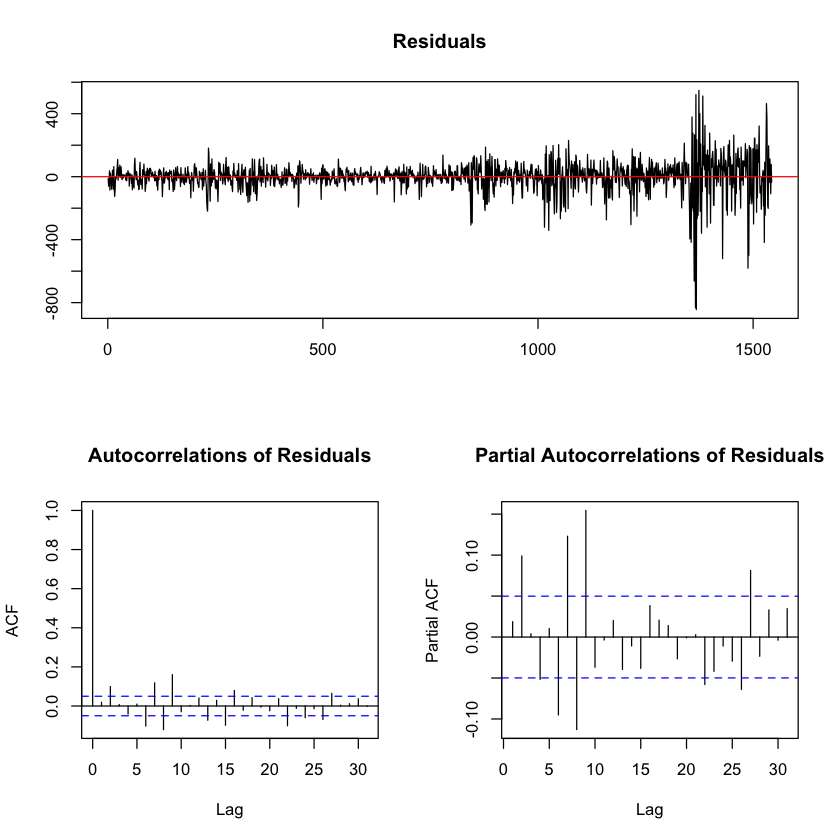

In [14]:
plot(x3)

---
---

## Finding the optimal lag ( $p$ )

---
#### $p^* = 8$ for BTC

In [150]:
VARselect(btc_usd$'Adj Close')

,1,2,3,4,5,6,7,8,9,10
AIC(n),11.62287,11.62379,11.62354,11.62246,11.62374,11.62504,11.62421,11.61613,11.61625,11.61741
HQ(n),11.62546,11.62768,11.62872,11.62892,11.63151,11.63409,11.63455,11.62778,11.62919,11.63164
SC(n),11.62982,11.63422,11.63745,11.63984,11.64460,11.64937,11.65202,11.64742,11.65102,11.65565
FPE(n),111621.39391,111724.86628,111696.77450,111575.43619,111719.28667,111863.66015,111770.81713,110872.13490,110885.31902,111014.00669


---
#### $p^* = 6$ for GOLD FUTURES

In [149]:
VARselect(gc_f$'Adj Close')

,1,2,3,4,5,6,7,8,9,10
AIC(n),5.174874,5.175673,5.176575,5.177751,5.175960,5.172633,5.172895,5.173339,5.174633,5.175885
HQ(n),5.177461,5.179553,5.181749,5.184219,5.183721,5.181688,5.183244,5.184981,5.187569,5.190114
SC(n),5.181827,5.186102,5.190481,5.195133,5.196818,5.196968,5.200706,5.204627,5.209398,5.214125
FPE(n),176.774308,176.915573,177.075276,177.283725,176.966411,176.378687,176.424825,176.503201,176.731858,176.953141


---
#### $p^* = 10$ for NASDAQ INDEX

In [148]:
VARselect(nasdaq$'Adj Close')

,1,2,3,4,5,6,7,8,9,10
AIC(n),9.186665,9.148736,9.141020,9.141261,9.139346,9.140160,9.127160,9.112523,9.100033,9.083311
HQ(n),9.189252,9.152617,9.146194,9.147729,9.147107,9.149215,9.137509,9.124165,9.112969,9.097541
SC(n),9.193618,9.159165,9.154925,9.158643,9.160204,9.164495,9.154972,9.143811,9.134797,9.121552
FPE(n),9766.024908,9402.547267,9330.275147,9332.527444,9314.669473,9322.254929,9201.855465,9068.145527,8955.592782,8807.082935


----
---

##  VAR Model

In [18]:
min(nasdaq$Date)

[1] "2014-09-17"

In [155]:
max(nasdaq$Date)

[1] "2020-11-20"

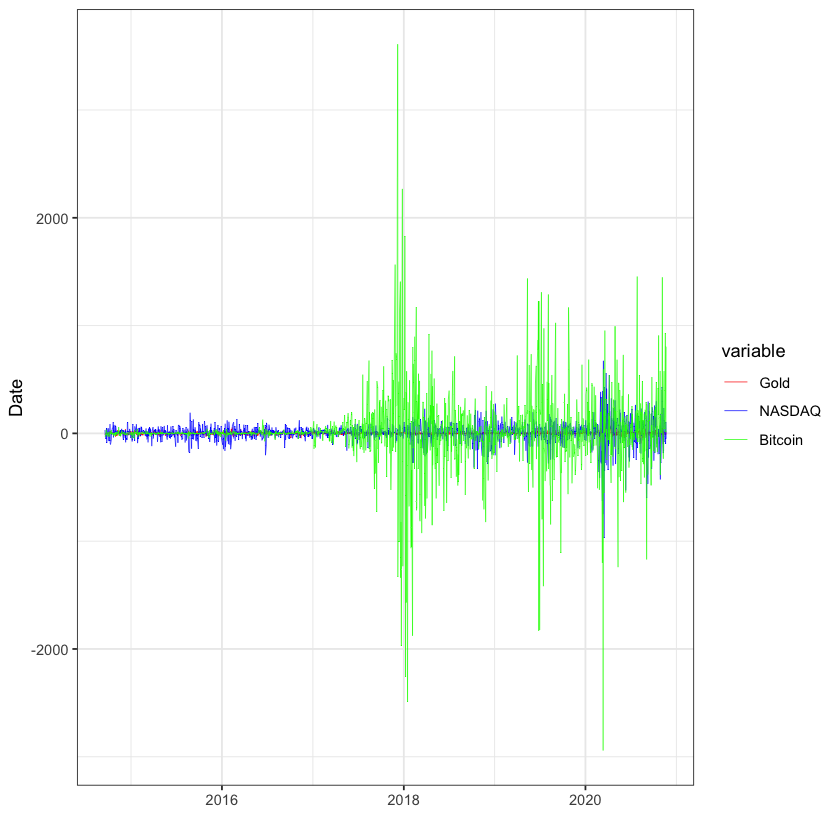

In [141]:
nasdaq__ = subset(nasdaq,select=c('Date','Adj Close'))

nadaq_diff = diff(nasdaq__$'Adj Close')

nasdaq__ = nasdaq__[-1,]

nasdaq__$'NASDAQ' = nadaq_diff

gold__ = subset(gc_f,select=c('Date','Adj Close'))

gold_diff = diff(gold__$'Adj Close')

gold__ = gold__[-1,]

gold__$'Gold' = gold_diff

btc__ = subset(btc_usd,select=c('Date','Adj Close'))

btc_diff = diff(btc__$'Adj Close')

btc__ = btc__[-1,]

btc__$'Bitcoin' = btc_diff

newData <- melt(list(df1 = gold__, df2 = nasdaq__, df3 = btc__), id.vars = "Date")

newData <- newData[newData$variable != 'Adj Close',]

#Specify your colour vector
cols <- c("red", "blue", "green")

#Plot data and specify the manual scale
ggplot(newData, aes(Date, value, colour = variable)) + 
  geom_line(size=0.2) +
  scale_colour_manual(values = cols) +
  labs(x = "", y = "Date") +
  theme_bw()

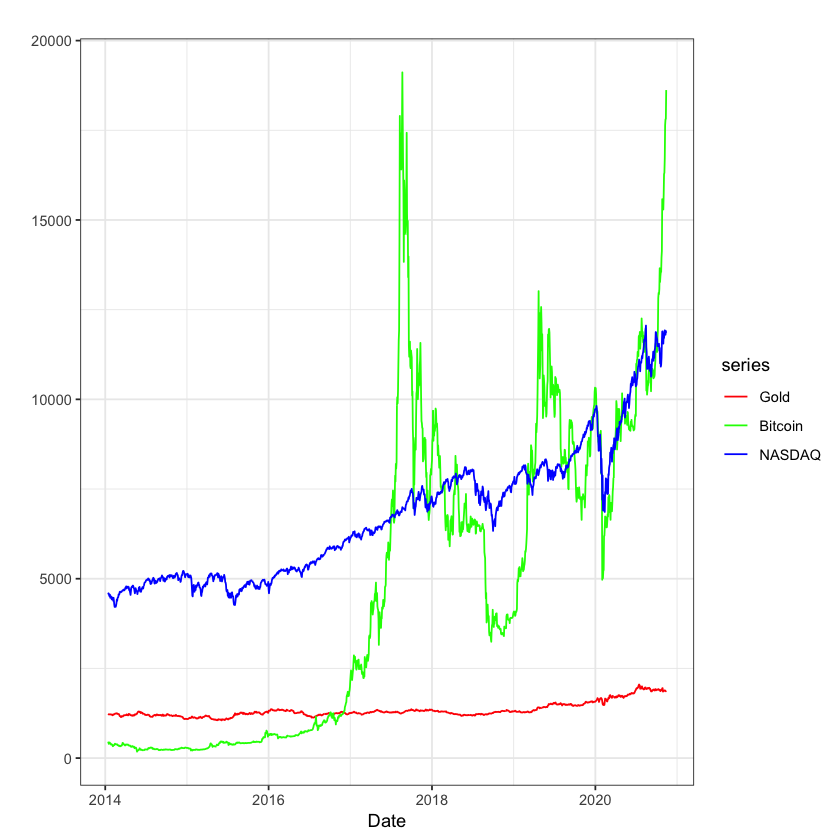

In [185]:
gold_f_ts <- ts(gc_f$'Adj Close', start = c(2014,9), frequency = 226)
btc_ts    <- ts(btc_usd$'Adj Close', start = c(2014,9), frequency = 226 )
nasdaq_ts <- ts(nasdaq$'Adj Close', start = c(2014, 9), frequency = 226)
autoplot(cbind(gold_f_ts, btc_ts, nasdaq_ts)) +
  labs(y = "", x = "Date")  +
  scale_color_manual(labels = c("Gold", "Bitcoin", "NASDAQ"), values = c("red", "green", "blue")) +
  theme_bw()

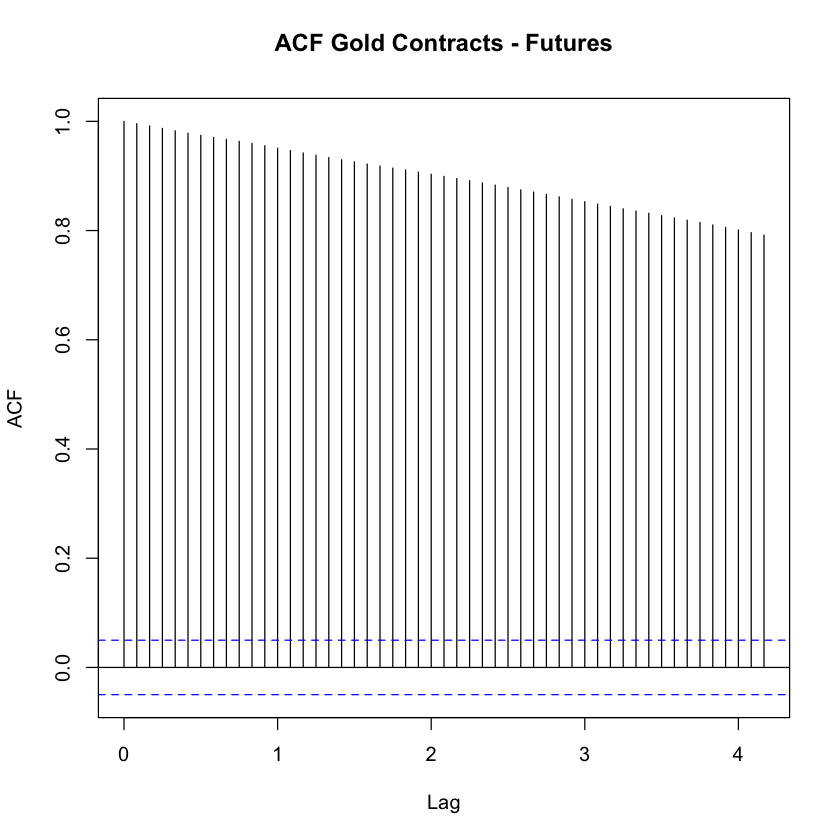

In [39]:
acf(gold_f_ts, main="ACF Gold Contracts - Futures", lag.max=50)

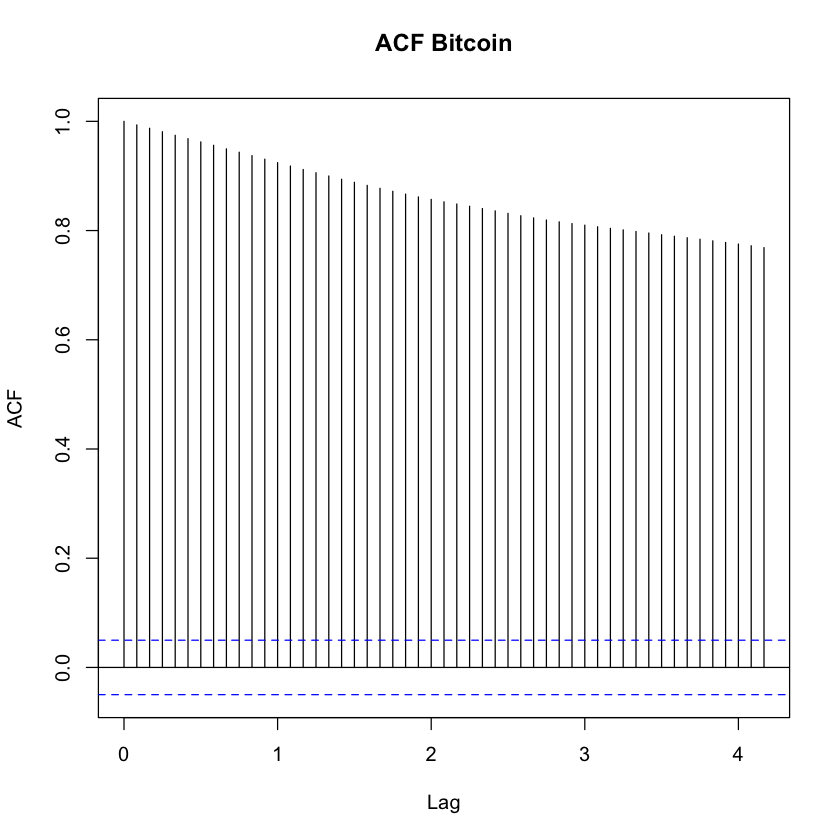

In [37]:
acf(btc_ts, main = "ACF Bitcoin", lag.max=50)

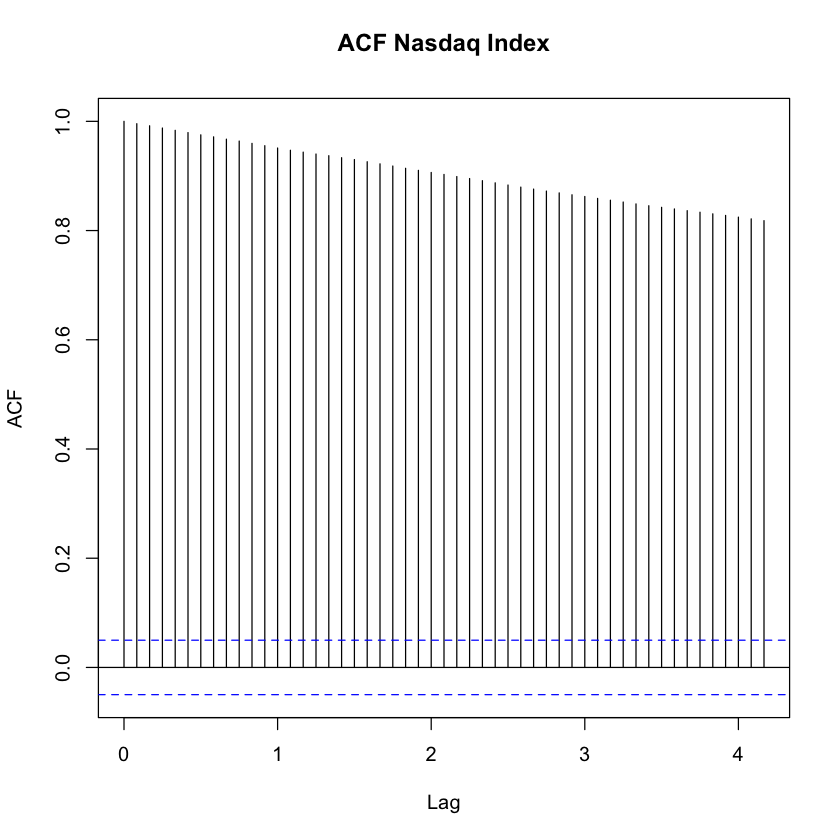

In [38]:
acf(nasdaq_ts, main = "ACF Nasdaq Index", lag.max=50)

In [215]:
btc_gold <- cbind(btc_usd$'Adj Close', gc_f$'Adj Close')
model1 <- VAR(btc_gold, p=6, type = "const", season = NULL, exog = NULL)
summary(model1)

Warning message in VAR(btc_gold, p = 6, type = "const", season = NULL, exog = NULL):
“No column names supplied in y, using: y1, y2 , instead.
”


VAR Estimation Results:
Endogenous variables: y1, y2 
Deterministic variables: const 
Sample size: 1539 
Log Likelihood: -17252.479 
Roots of the characteristic polynomial:
1.001 0.9925 0.6027 0.6027 0.5767 0.5767 0.5649 0.516 0.516 0.4467 0.3676 0.3676
Call:
VAR(y = btc_gold, p = 6, type = "const", exogen = NULL)


Estimation results for equation y1: 
y1 = y1.l1 + y2.l1 + y1.l2 + y2.l2 + y1.l3 + y2.l3 + y1.l4 + y2.l4 + y1.l5 + y2.l5 + y1.l6 + y2.l6 + const 

        Estimate Std. Error t value Pr(>|t|)    
y1.l1  9.733e-01  2.580e-02  37.730   <2e-16 ***
y2.l1 -1.014e-01  6.466e-01  -0.157   0.8754    
y1.l2  6.049e-02  3.601e-02   1.680   0.0932 .  
y2.l2  4.861e-01  9.032e-01   0.538   0.5905    
y1.l3  1.653e-02  3.602e-02   0.459   0.6463    
y2.l3 -1.090e+00  9.016e-01  -1.209   0.2268    
y1.l4 -4.367e-02  3.605e-02  -1.211   0.2259    
y2.l4 -3.636e-01  9.014e-01  -0.403   0.6867    
y1.l5  3.623e-03  3.609e-02   0.100   0.9201    
y2.l5 -4.360e-01  9.022e-01  -0.483   0.6289 

In [217]:
nasdaq_gold <- cbind(nasdaq$'Adj Close',gc_f$'Adj Close')
model2 <- VAR(nasdaq_gold, p = 6, type = "const", season = NULL, exog = NULL)
summary(model2)

Warning message in VAR(nasdaq_gold, p = 6, type = "const", season = NULL, exog = NULL):
“No column names supplied in y, using: y1, y2 , instead.
”


VAR Estimation Results:
Endogenous variables: y1, y2 
Deterministic variables: const 
Sample size: 1539 
Log Likelihood: -15340.138 
Roots of the characteristic polynomial:
1.001 0.9917 0.6229 0.6229 0.6121 0.6121 0.6067 0.6067 0.5355 0.4547 0.4547 0.3764
Call:
VAR(y = nasdaq_gold, p = 6, type = "const", exogen = NULL)


Estimation results for equation y1: 
y1 = y1.l1 + y2.l1 + y1.l2 + y2.l2 + y1.l3 + y2.l3 + y1.l4 + y2.l4 + y1.l5 + y2.l5 + y1.l6 + y2.l6 + const 

       Estimate Std. Error t value Pr(>|t|)    
y1.l1   0.81450    0.02562  31.797  < 2e-16 ***
y2.l1   0.32405    0.18408   1.760   0.0785 .  
y1.l2   0.28739    0.03294   8.725  < 2e-16 ***
y2.l2   0.51379    0.25718   1.998   0.0459 *  
y1.l3  -0.08657    0.03373  -2.567   0.0104 *  
y2.l3  -1.08902    0.25729  -4.233 2.45e-05 ***
y1.l4  -0.07594    0.03353  -2.265   0.0237 *  
y2.l4  -0.07003    0.25854  -0.271   0.7865    
y1.l5   0.07858    0.03281   2.395   0.0167 *  
y2.l5   0.53023    0.25855   2.051   0.0405 *  
y1

In [221]:
nasdaq_btc <- cbind(nasdaq$'Adj Close', btc_usd$'Adj Close')
model3 <- VAR(nasdaq_btc, p = 2, type = "const", season = NULL, exog = NULL)
summary(model3)

Warning message in VAR(nasdaq_btc, p = 2, type = "const", season = NULL, exog = NULL):
“No column names supplied in y, using: y1, y2 , instead.
”


VAR Estimation Results:
Endogenous variables: y1, y2 
Deterministic variables: const 
Sample size: 1543 
Log Likelihood: -20364.129 
Roots of the characteristic polynomial:
1.002 0.988 0.1958 0.01013
Call:
VAR(y = nasdaq_btc, p = 2, type = "const", exogen = NULL)


Estimation results for equation y1: 
y1 = y1.l1 + y2.l1 + y1.l2 + y2.l2 + const 

       Estimate Std. Error t value Pr(>|t|)    
y1.l1  0.804715   0.025386  31.699  < 2e-16 ***
y2.l1 -0.002422   0.007540  -0.321    0.748    
y1.l2  0.193865   0.025425   7.625 4.25e-14 ***
y2.l2  0.003775   0.007546   0.500    0.617    
const  8.960082  13.798676   0.649    0.516    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 96.68 on 1538 degrees of freedom
Multiple R-Squared: 0.9973,	Adjusted R-squared: 0.9973 
F-statistic: 1.406e+05 on 4 and 1538 DF,  p-value: < 2.2e-16 


Estimation results for equation y2: 
y2 = y1.l1 + y2.l1 + y1.l2 + y2.l2 + const 

        Estimate Std. Error t valu

---
---
## Granger Causality

This test can check if one variable can affect another in a time perspective. Rather than testing whether Y causes X, the Granger Causality tests whether Y forecasts X, for p-values lower than 0.05 we can discart the model.

Below we can see that the Granger test for the pair NASDAQ and Bitcoin indicates no relation, although it can be the case for a non-linear relation between the assets, the pair will be discarted in the following analysis.

In [222]:
grangertest(nasdaq_btc, order = 8)

Res.Df,Df,F,Pr(>F)
1520,NA,NA,NA
1528,-8,2.547201,0.009319838


In [218]:
grangertest(nasdaq_gold, order = 6)

Res.Df,Df,F,Pr(>F)
1526,NA,NA,NA
1532,-6,1.144639,0.3338556


In [219]:
grangertest(btc_gold, order = 6)

Res.Df,Df,F,Pr(>F)
1526,NA,NA,NA
1532,-6,1.05752,0.3861727


---
---

## Impulse Response

### model 1: Bitcoin x Gold

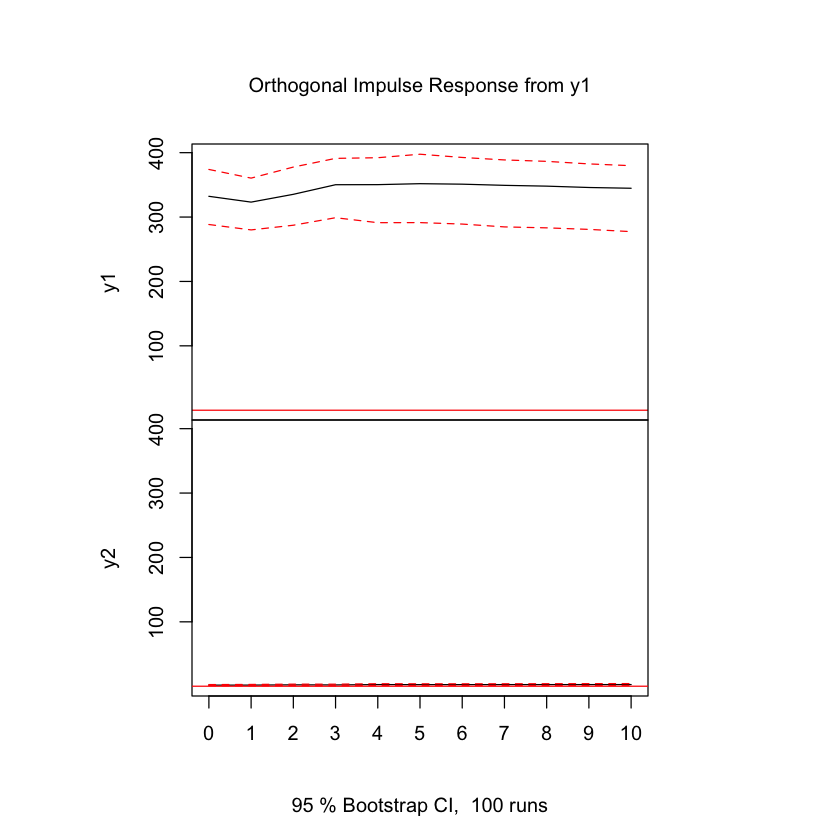

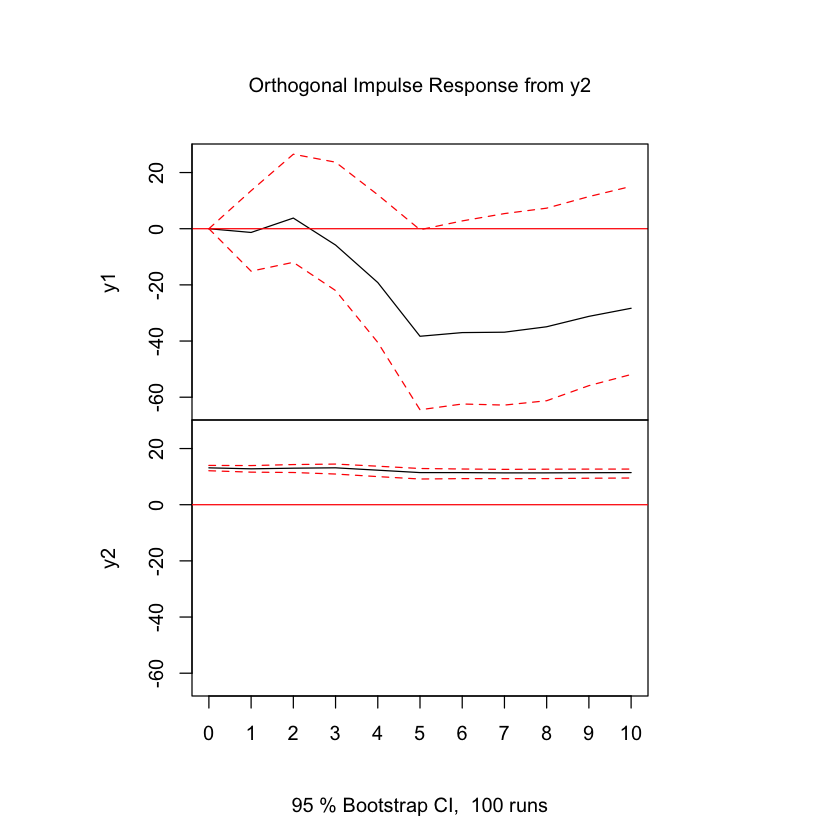

In [223]:
plot(irf(model1, n.ahead = 10))

### model 2: NASDAQ x Gold

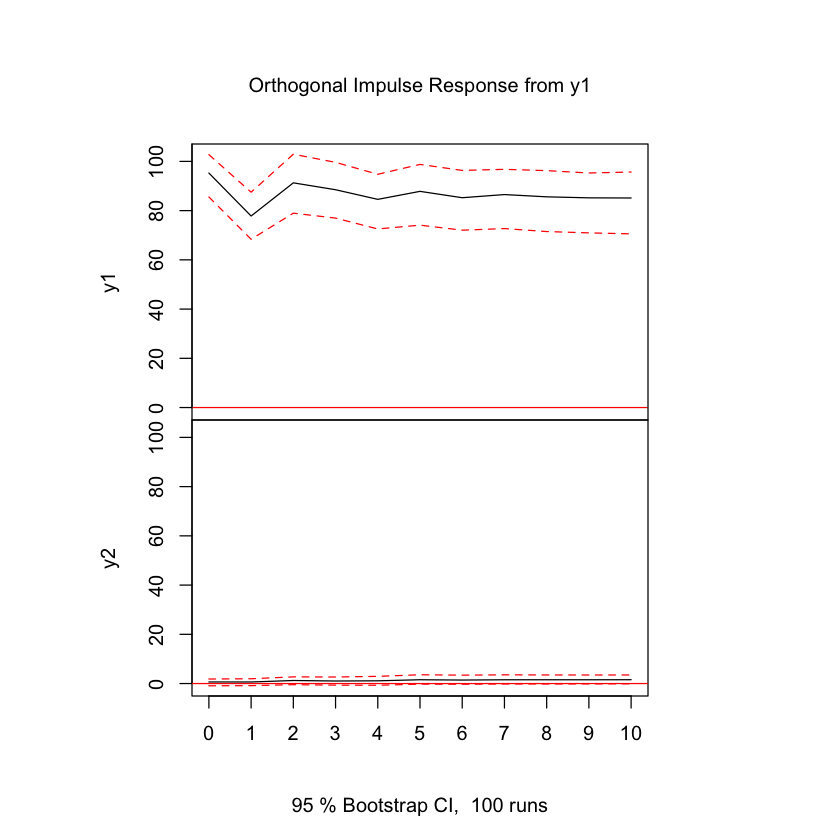

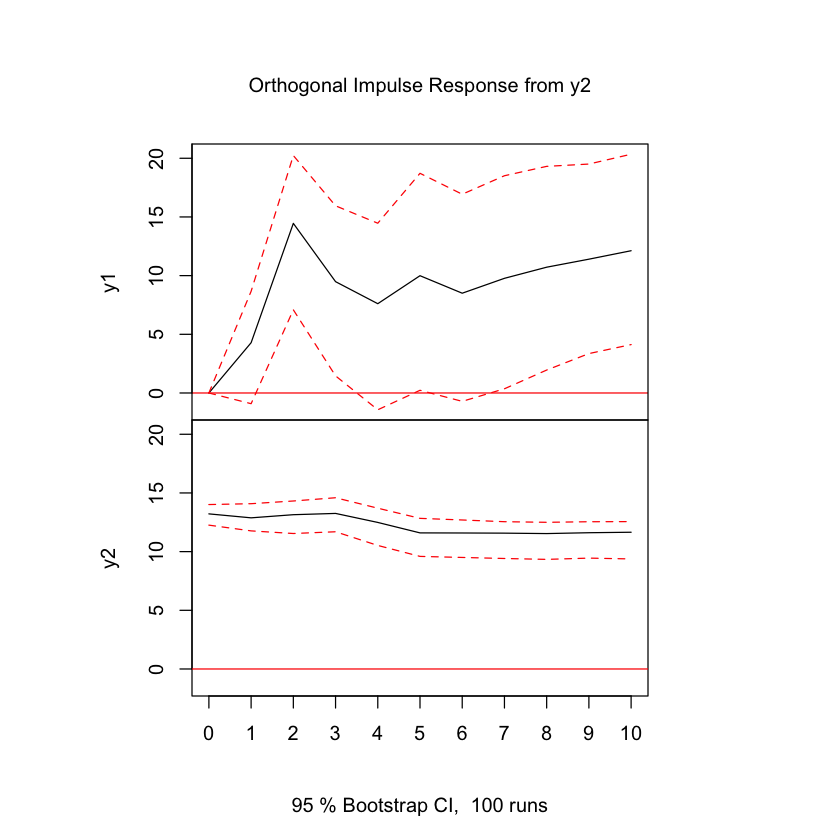

In [224]:
plot(irf(model2, n.ahead = 10))

---
# Conclusion: